In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
%matplotlib inline

In [2]:
rawData = pd.read_csv('ED_COVID19_dashboard.csv')

In [3]:
# identify covid cases
rawData.loc[(rawData.ED_LAB_COVID19=="Positive") | (rawData.ED_LAB_COVID19=="Presumptive Positive"), 'ED_LAB_COVID19']  ="Detected"   
rawData.loc[(rawData.ED_LAB_COVID19=="Not Detected"), 'ED_LAB_COVID19'] ="Not detected"  
rawData = rawData.loc[(rawData.ED_LAB_COVID19 == 'Detected') | (rawData.ED_LAB_COVID19 == 'Not detected')]
rawData['covid'] = rawData.ED_LAB_COVID19=="Detected"
rawData = rawData.loc[rawData.covid]

In [4]:
# clean outcomes
rawData.loc[(rawData.ED_PM_EXPIRED_IN_ED_YN=="Y"), 'ED_ADMIT_TO_ICU_YN'] = 1
rawData['icu'] = rawData.ED_ADMIT_TO_ICU_YN=="Y"


In [5]:
rawData.ED_LAB_COVID19.value_counts()

Detected    301
Name: ED_LAB_COVID19, dtype: int64

In [6]:
pd.crosstab(rawData.covid, rawData.icu, dropna=False )

icu,False,True
covid,,
True,260,41


In [7]:
# truncate high low lab values and convert to floats
rawData.ED_LAB_CRP.replace('<0.2', 0.1, inplace=True)

rawData.ED_LAB_DDIMER.replace('<0.17', 0.085, inplace=True)
rawData.ED_LAB_DDIMER.replace('>35.00', 40, inplace=True)

rawData.ED_LAB_FERRITIN.replace('>16500.0', 17000, inplace=True)
rawData.ED_LAB_FERRITIN.replace('>1650.0', 17000, inplace=True)

rawData.ED_LAB_IL6.replace('>3670.0', 4100, inplace=True)
rawData.ED_LAB_IL6.replace('>4060.0', 4100, inplace=True)

rawData.ED_LAB_CMP_ALT.replace('<8', 4, inplace=True)

rawData.ED_LAB_HSTROP0.replace('<6', 3, inplace=True)
rawData.ED_LAB_HSTROP2.replace('<6', 3, inplace=True)

rawData.ED_LAB_CBC_PLT.replace('<2', 1, inplace=True)
rawData.ED_LAB_CMP_CR.replace('SEE BELOW', np.nan, inplace=True)
rawData.ED_LAB_CMP_CR.replace('<0.10', 0.005, inplace=True)

rawData.ED_LAB_CBC_HGB.replace('SEE BELOW', np.nan, inplace=True)
rawData.ED_LAB_VBG_LAC.replace('SEE BELOW', np.nan, inplace=True)


rawData.ED_LAB_CRP = rawData.ED_LAB_CRP.astype('float')
rawData.ED_LAB_DDIMER = rawData.ED_LAB_DDIMER.astype('float')
rawData.ED_LAB_FERRITIN = rawData.ED_LAB_FERRITIN.astype('float')
rawData.ED_LAB_IL6 = rawData.ED_LAB_IL6.astype('float')
rawData.ED_LAB_CMP_ALT = rawData.ED_LAB_CMP_ALT.astype('float')
rawData.ED_LAB_HSTROP0 = rawData.ED_LAB_HSTROP0.astype('float')
rawData.ED_LAB_HSTROP2 = rawData.ED_LAB_HSTROP2.astype('float')
rawData.ED_LAB_CBC_PLT = rawData.ED_LAB_CBC_PLT.astype('float')
rawData.ED_LAB_CMP_CR = rawData.ED_LAB_CMP_CR.astype('float')
rawData.ED_LAB_CBC_HGB =  rawData.ED_LAB_CBC_HGB.astype('float')
rawData.ED_LAB_VBG_LAC =  rawData.ED_LAB_VBG_LAC.astype('float')
rawData.ED_LAB_LDH =  rawData.ED_LAB_LDH.astype('float')
rawData.ED_LAB_CMP_ALB =  rawData.ED_LAB_CMP_ALB.astype('float')

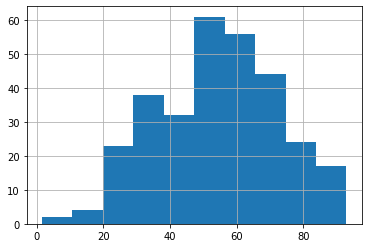

In [8]:
rawData.AGE_AT_VISIT_YRS.hist()

In [9]:
rawData.GENDER.value_counts()
rawData['female'] = rawData.GENDER=="F"

In [10]:
rawData['highFi02'] = rawData.TRIAGE_FIO2 > 50

In [11]:
rawData = rawData[['AGE_AT_VISIT_YRS', 'female', 'TRIAGE_SBP', 'TRIAGE_DBP', 'TRIAGE_HR', 'TRIAGE_TEMP',
                   'highFi02', 'ED_LAB_CRP', 'ED_LAB_DDIMER', 'ED_LAB_FERRITIN', 'ED_LAB_CBC_PLT', 'ED_LAB_CBC_LYM',
                   'ED_LAB_CMP_CR', 'ED_LAB_CMP_TBILI', 'ED_LAB_HSTROP0', 'ED_LAB_IL6', 'covid', 'icu',
                   'ED_LAB_CBC_HGB', 'ED_LAB_VBG_LAC', 'ED_LAB_LDH', 'ED_LAB_CMP_ALB']]

In [12]:
# impute missing lab and vitals values

import statsmodels.imputation.mice as mice

def ols_formula(df, dependent_var):
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    fml = ''
    for col in df_columns:
        fml = fml + ' + ' + col
    return fml

imputedData = mice.MICEData(rawData)

for var in ['AGE_AT_VISIT_YRS', 'female', 'TRIAGE_SBP', 'TRIAGE_DBP', 'ED_LAB_CRP', 'ED_LAB_DDIMER', 
            'ED_LAB_FERRITIN', 'ED_LAB_CBC_PLT', 'ED_LAB_CMP_CR', 'ED_LAB_CMP_TBILI', 'ED_LAB_HSTROP0', 
            'ED_LAB_IL6', 'ED_LAB_CBC_LYM', 'ED_LAB_CBC_HGB', 'ED_LAB_VBG_LAC', 'ED_LAB_LDH', 'ED_LAB_CMP_ALB']:
    imputedData.set_imputer(var, formula=ols_formula(rawData, var))

imputedData.update_all(20)

In [13]:
cleanedData = imputedData.data

In [14]:
cleanedData.rename(columns={'AGE_AT_VISIT_YRS' : 'age', 'TRIAGE_SBP' : 'sbp', 'TRIAGE_DBP' : 'dbp',
                            'TRIAGE_HR' : 'hr', 'TRIAGE_TEMP' : 'temp', 'ED_LAB_CRP' : 'crp', 
                            'ED_LAB_DDIMER' : 'dDimer', 'ED_LAB_FERRITIN' : 'ferritin',
                            'ED_LAB_CBC_PLT' : 'platelets', 'ED_LAB_CMP_CR' : 'creatinine',  
                            'ED_LAB_CMP_TBILI' : 'tbili', 'ED_LAB_HSTROP0' : 'hsTrop', 
                            'ED_LAB_IL6' : 'il6', 'ED_LAB_CBC_LYM' : 'lymph',
                            'ED_LAB_CBC_HGB': 'hgb', 'ED_LAB_VBG_LAC':'lac', 'ED_LAB_LDH':'ldh',
                            'ED_LAB_CMP_ALB': 'albumin'}, inplace=True)

In [15]:
cleanedData

,age,female,sbp,dbp,hr,temp,highFi02,crp,dDimer,ferritin,...,creatinine,tbili,hsTrop,il6,covid,icu,hgb,lac,ldh,albumin
0,58.529,False,111.0,90.0,104.0,97.5,False,0.5,3.09,100.0,...,0.89,5.9,25.0,5.5,True,False,15.8,2.9,375.0,3.6
1,46.963,True,121.0,77.0,103.0,100.2,False,6.0,0.82,297.9,...,1.22,0.2,100.0,67.3,True,False,11.9,1.2,621.0,3.7
2,57.913,False,140.0,77.0,85.0,99.5,False,0.1,1.34,289.9,...,1.50,0.6,50.0,106.8,True,True,12.1,0.9,225.0,4.4
3,58.966,False,117.0,72.0,89.0,102.6,False,19.0,1.76,356.8,...,3.35,0.2,62.0,11.6,True,False,10.1,0.8,409.0,3.5
4,53.185,True,114.0,76.0,80.0,98.9,False,4.5,0.23,2120.3,...,0.84,1.4,15.0,49.6,True,False,13.2,1.5,396.0,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,26.133,False,126.0,84.0,121.0,99.1,False,3.4,0.80,563.7,...,1.10,0.6,9.0,60.2,True,False,15.7,1.0,251.0,5.3
297,56.593,True,155.0,83.0,107.0,98.3,False,19.0,0.51,1632.5,...,0.84,0.5,7.0,136.7,True,False,11.5,1.0,170.0,4.3
298,59.814,False,139.0,71.0,95.0,103.3,False,10.2,1.21,951.4,...,0.94,0.6,9.0,365.7,True,False,13.4,1.1,505.0,4.6
299,64.543,True,163.0,87.0,85.0,102.5,False,0.2,4.13,1583.7,...,1.15,0.5,13.0,47.7,True,False,10.9,1.4,269.0,3.9


In [16]:
# crude sofa score on imputed dataset
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score#evidence

# pao2/fi02
cleanedData['sofa'] = 0 # for the PaO2/fio2 ratio — looks like almost all our peopel are on room air, and we don't have pa02 on many 
cleanedData.loc[cleanedData.highFi02, 'sofa'] = 2 # crudely give elevated points for high Fi01, 

# platelets
sofaPlateletPoints = {0 : 4, 1 : 3, 2: 2, 3: 1, 4: 0}
cleanedData['plateletCat'] = pd.cut(cleanedData.platelets, [0, 20, 49, 99, 149, 10000]).values.codes
cleanedData['plateletPoints'] = [sofaPlateletPoints[cat] for cat in cleanedData.plateletCat]
cleanedData['sofa'] = cleanedData.sofa + cleanedData.plateletPoints

#gcs - missing...will just impute 0.2 points for eerybody...most are going to be very low
cleanedData['sofa'] = cleanedData.sofa + 0.2 

# t bili
cleanedData['biliCat'] = pd.cut(cleanedData.tbili, [0, 1.2, 1.99, 5.99, 11.99, 100]).values.codes
cleanedData['sofa'] = cleanedData.sofa + cleanedData.biliCat

# blood pressure — no pressor data for now...
cleanedData['map'] = cleanedData.sbp * 1/3 + cleanedData.dbp * 2/3
cleanedData.loc[cleanedData.map < 70, 'sofa'] = cleanedData.sofa + 1

# creatinine
cleanedData['creatCat'] = pd.cut(cleanedData.creatinine, [0, 1.19, 1.99, 3.49, 4.99, 100]).values.codes
cleanedData['sofa'] = cleanedData.sofa + cleanedData.creatCat


In [17]:
modelData = cleanedData[['age', 'female', 'crp','dDimer', 'ferritin', 'hsTrop','icu', 'sofa', 
                         'lymph', 'hgb', 'lac', 'ldh', 'albumin']]

In [18]:
modelData.head()

,age,female,crp,dDimer,ferritin,hsTrop,icu,sofa,lymph,hgb,lac,ldh,albumin
0,58.529,False,0.5,3.09,100.0,25.0,False,2.2,26.2,15.8,2.9,375.0,3.6
1,46.963,True,6.0,0.82,297.9,100.0,False,1.2,2.1,11.9,1.2,621.0,3.7
2,57.913,False,0.1,1.34,289.9,50.0,True,1.2,19.1,12.1,0.9,225.0,4.4
3,58.966,False,19.0,1.76,356.8,62.0,False,2.2,18.2,10.1,0.8,409.0,3.5
4,53.185,True,4.5,0.23,2120.3,15.0,False,1.2,40.1,13.2,1.5,396.0,3.8


In [19]:
# crude priors from:  Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study. The Lancet, 1–9. http://doi.org/10.1016/S0140-6736(20)30566-3
import pymc3 as pm

# mean center all the variables...
#for var in ['crp', 'dDimer', 'ferritin', 'hsTrop', 'sofa','lymph', 'hbg', 'lac', 'ldh', 'albumin']:
#     modelData[var] = modelData[var] - modelData[var].mean()


In [20]:
def getBetaNameForLab(lab):
    return 'beta' + lab.capitalize()

labs = ['crp', 'dDimer', 'ferritin', 'hsTrop', 'hgb', 'lac', 'ldh', 'albumin']

with pm.Model() as logitICUWIthPriors:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
    betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
    betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
    betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)


    
    # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
    for lab in labs:
        name = getBetaNameForLab(lab)
        setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
        setattr(logitICUWIthPriors, lab, pm.Data(lab, modelData[lab]))
        
    
    # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
    mu = alpha + betaAge * modelData.age + betaSofa * modelData.sofa + betaLymph * modelData.lymph + betaFemale * modelData.female
    for lab  in labs:   
        mu += getattr(logitICUWIthPriors, getBetaNameForLab(lab)) * getattr(logitICUWIthPriors, lab)
        
    θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=modelData.icu)

    trace_ICU = pm.sample(1000, tune=2000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaAlbumin, betaLdh, betaLac, betaHgb, betaHstrop, betaFerritin, betaDdimer, betaCrp, betaFemale, betaLymph, betaSofa, betaAge, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:35<00:00, 340.51draws/s]


In [21]:
ppc = pm.sample_ppc(trace_ICU, model=logitICUWIthPriors, samples=500)
modelData['posteriorProbabilities'] = ppc['y_1'].mean(axis=0)

preds = np.rint(modelData['posteriorProbabilities']).astype('int')
print(f'Accuracy: {accuracy_score(modelData.icu, preds):.3f}')
print(f'f1 score: {f1_score(modelData.icu, preds):.3f}')
roc = roc_auc_score(modelData.icu, modelData.posteriorProbabilities)
print(f'ROC: {roc:.3f}')

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 828.32it/s]

Accuracy: 0.900
f1 score: 0.516
ROC: 0.835



/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
labsToKeep = []
marginalOutputsForLab = {}
marginalInputsForLab = {}
ninetyMinusTenForLab = {}


for var in labs:
    with logitICUWIthPriors:
        valuesToCheck = {'min': modelData[var].min(), '1st':modelData[var].quantile(0.01),
                         '10th':modelData[var].quantile(0.10), '25th':modelData[var].quantile(0.25), 
                         '50th':modelData[var].quantile(0.50), '75th':modelData[var].quantile(0.75), 
                         '90th':modelData[var].quantile(0.90), '99th':modelData[var].quantile(0.99),
                         'max':modelData[var].max()}
        ppcsAtValue = dict.fromkeys(valuesToCheck.keys())

        for key, value in valuesToCheck.items():
            pm.model.set_data({var: np.repeat(value, len(modelData))})
            pccsForLabValue = pm.sample_posterior_predictive(trace_ICU, samples=1000)
            ppcsAtValue[key] = pccsForLabValue['y_1'].mean(axis=0).mean()
            marginalOutputsForLab[var] = ppcsAtValue
            marginalInputsForLab[var] = valuesToCheck
        ninetyMinusTen = ppcsAtValue['90th'] - ppcsAtValue['10th']
        ninetyMinusTenForLab[var] = ninetyMinusTen

        if np.abs(ninetyMinusTen) > 0.05:
            labsToKeep.append(var)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 890.12it/s]


In [23]:
labsToKeep

['crp', 'ldh']

In [24]:
ninetyMinusTenForLab

{'crp': 0.058009966777408634,
 'dDimer': 0.005916943521594692,
 'ferritin': -0.00965116279069761,
 'hsTrop': -0.02424584717607975,
 'hgb': 0.0030232558139534627,
 'lac': 0.0020398671096345244,
 'ldh': 0.19207308970099668,
 'albumin': 0.0006910299003323184}

In [25]:
with logitICUWIthPriors:

    data = az.from_pymc3(
        trace=trace_ICU,
        prior=pm.sample_prior_predictive(),
        posterior_predictive=ppc,
        model=logitICUWIthPriors
    )


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [26]:
az.summary(trace_ICU, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                      'betaFemale', 'betaSofa', 'alpha' ])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betaCrp,0.039,0.024,-0.007,0.083,0.000,0.000,4788.0,3831.0,4794.0,2812.0,1.0
betaFerritin,-0.000,0.000,-0.000,0.000,0.000,0.000,4090.0,1921.0,4132.0,2794.0,1.0
betaDdimer,0.017,0.030,-0.038,0.071,0.000,0.000,5284.0,2435.0,5316.0,2940.0,1.0
betaAge,0.026,0.014,0.000,0.052,0.000,0.000,3656.0,2622.0,3656.0,2541.0,1.0
betaHstrop,-0.005,0.009,-0.022,0.010,0.000,0.000,4654.0,2693.0,4722.0,3250.0,1.0
betaLymph,-0.035,0.026,-0.087,0.011,0.000,0.000,4200.0,3229.0,4252.0,2864.0,1.0
betaHgb,0.008,0.046,-0.070,0.102,0.001,0.001,4847.0,1878.0,4854.0,3048.0,1.0
betaLac,0.012,0.049,-0.082,0.100,0.001,0.001,5581.0,1828.0,5578.0,2877.0,1.0
betaLdh,0.006,0.001,0.003,0.008,0.000,0.000,3936.0,3790.0,3947.0,3053.0,1.0
betaAlbumin,-0.007,0.050,-0.094,0.089,0.001,0.001,6305.0,1543.0,6351.0,2615.0,1.0


/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2a263290>,
      dtype=object)

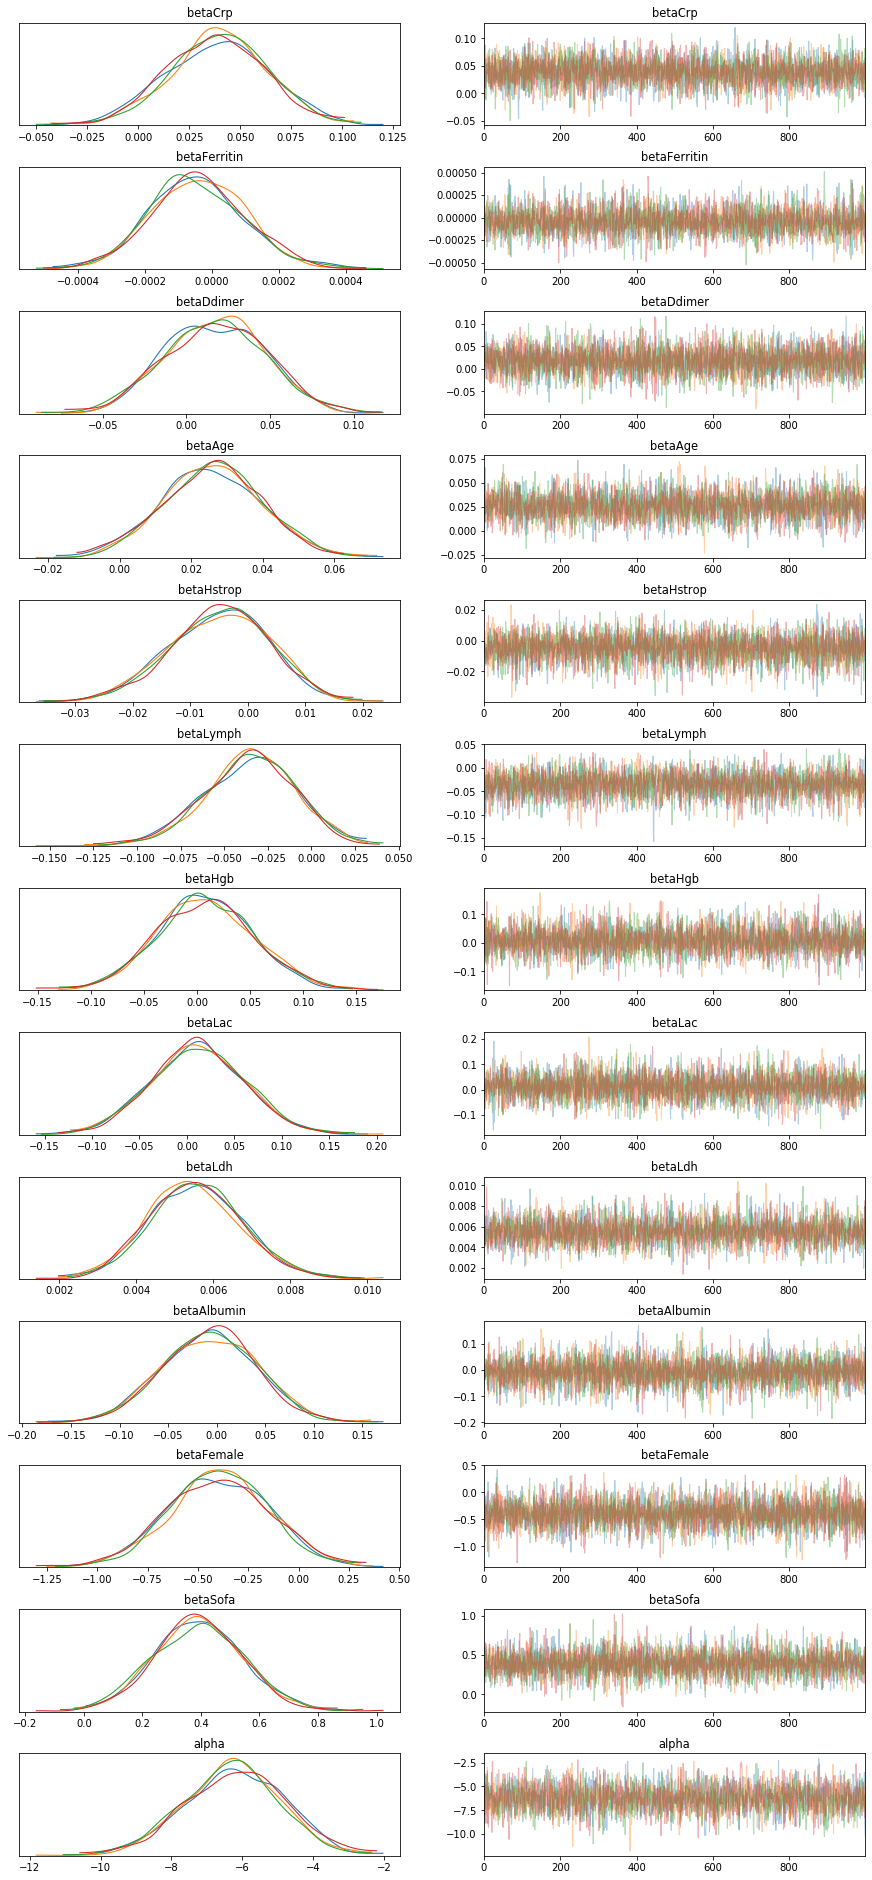

In [27]:
az.plot_trace(trace_ICU, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                    'betaFemale', 'betaSofa', 'alpha'])

In [28]:
outputDF = pd.DataFrame({'predictedProb' : modelData.posteriorProbabilities, 'icu' : modelData.icu})
outputDF['icuDecile'] = pd.qcut(outputDF.predictedProb, 10)

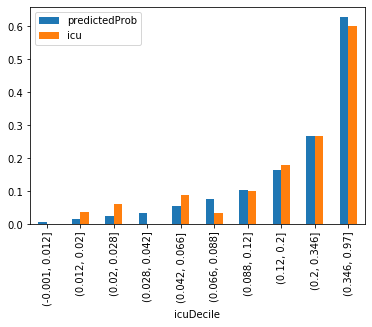

In [29]:
from datetime import date


# calibration looks perfectly decent.
outputDF.groupby('icuDecile').mean().plot.bar()
plt.savefig(f'calibration{str(date.today())}.jpg')

In [30]:
modelCoefficients = az.summary(trace_ICU, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                      'betaFemale', 'betaSofa', 'alpha'])[['mean', 'sd']]
modelCoefficients.rename(columns={'mean': 'beta', 'sd':'sdBeta'}, inplace=True)
for key, value in ninetyMinusTenForLab.items():
    modelCoefficients.loc[(modelCoefficients.index == getBetaNameForLab(key)),'priority'] = np.abs(value)
    modelCoefficients.loc[(modelCoefficients.index == getBetaNameForLab(key)),'p50'] = modelData[key].quantile(0.50)
    
for i, row in modelCoefficients.iterrows():
    if row.name[0:4] == 'beta':
        modelCoefficients.loc[modelCoefficients.index==row.name, 'name'] = row.name[4:].lower()
    else:
        modelCoefficients.loc[modelCoefficients.index==row.name, 'name'] = row.name

In [31]:
modelCoefficients

,beta,sdBeta,priority,p50,name
betaCrp,0.039,0.024,0.058010,6.7,crp
betaFerritin,-0.000,0.000,0.009651,713.6,ferritin
betaDdimer,0.017,0.030,0.005917,0.8,ddimer
betaAge,0.026,0.014,NaN,NaN,age
betaHstrop,-0.005,0.009,0.024246,13.0,hstrop
betaLymph,-0.035,0.026,NaN,NaN,lymph
betaHgb,0.008,0.046,0.003023,13.6,hgb
betaLac,0.012,0.049,0.002040,1.4,lac
betaLdh,0.006,0.001,0.192073,373.0,ldh
betaAlbumin,-0.007,0.050,0.000691,4.1,albumin


In [36]:
import json

modelCoefficients.to_stata(f'icuAdmitCoeffs-{str(date.today())}.dta')
modelData.to_stata(f'modelData-{str(date.today())}.dta')


modelPerformance = {}
modelPerformance['roc'] = roc
modelPerformance['labsToKeep']=labsToKeep

with open(f'icuModelPerformance-{str(date.today())}.json', 'w') as outfile:
    json.dump(modelPerformance, outfile)

In [33]:
# workflow...

# download data
# clean datat (in this worksheet)
# impute missing values
# run baseline model
# prioritize coefficients
# export coefficients, data file and model performance
# update the priority in teh UI — done
# 

In [34]:
# there is a fairly reasonable agreement between our baseline bayesian model and a default-tuned elastic net
# that seesm liek a decent argument that our pessimism was calibrated reasonably...

In [35]:
from glmnet import LogitNet

m = LogitNet()
m = m.fit(modelData.loc[:,!modelData.columns.in(['icu', 'posteriorProbabilities']), modelData.icu)

SyntaxError: invalid syntax (<ipython-input-35-3e104641e805>, line 4)

In [ ]:
modelData

In [ ]:
m.coef_